<a href="https://colab.research.google.com/github/ALLEN0607/ACME-Sales-Profit-Optimization-Analysis/blob/main/Acme_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print(np.__version__)
print(pd.__version__)

1.26.4
2.2.2


In [110]:
# Set random seed
np.random.seed(42)

# Define hierarchy
brands = ["Bobbi Brown", "Aveda"]
segments = {
    "Bobbi Brown": ["Lipstick", "Mascara", "Bronzer"],
    "Aveda": ["Toner", "Mascara", "Bronzer"]
}

# Generated data
data = []
for brand in brands:
  total_sales = np.random.randint(5000000, 10000000) # Brand sales
  contributions = np.random.dirichlet(np.ones(len(segments[brand])), size=1)[0] # Ensure the contribution adds up to 100%

  for i, segment in enumerate(segments[brand]):
    sales = int(total_sales * contributions[i]) # Allocate sales according to contribution
    margin = round(np.random.uniform(0.05, 0.20), 2) # 5%~20%
    trend = round(np.random.uniform(-0.05, 0.10), 2) # -5%~10%

    data.append([brand, segment, sales, margin, trend, round(contributions[i], 2)])


# Transform to DataFrame
df = pd.DataFrame(data, columns=["Brand", "Segment", "Sales", "Margin", "Trend", "Contribution"])
df.head()

,Brand,Segment,Sales,Margin,Trend,Contribution
0,Bobbi Brown,Lipstick,4879625,0.06,0.08,0.73
1,Bobbi Brown,Mascara,906635,0.14,0.06,0.14
2,Bobbi Brown,Bronzer,906482,0.05,0.10,0.14
3,Aveda,Toner,2469011,0.14,0.04,0.36
4,Aveda,Mascara,689,0.05,-0.05,0.00


In [111]:
# Check if the sum of Contribution per brand equals 1
contribution_check = df.groupby("Brand")["Contribution"].sum()
print("Contribution Check:\n", contribution_check)

# Normalize Contribution to ensure each brand's total contribution sums to 1
for brand in df["Brand"].unique():
    total_contribution = df[df["Brand"] == brand]["Contribution"].sum()  # Total contribution for the brand
    df.loc[df["Brand"] == brand, "Contribution"] /= total_contribution  # Normalize

# Verify total Sales per brand
sales_check = df.groupby("Brand")["Sales"].sum()
print(sales_check)

# Check for invalid Margin values
invalid_margin = df[(df["Margin"] < 0.05) | (df["Margin"] > 0.20)]
print("Invalid Margin:\n", invalid_margin)

# Check for invalid Trend values
invalid_trend = df[(df["Trend"] < -0.05) | (df["Trend"] > 0.10)]
print("Invalid Trend:\n", invalid_trend)

Contribution Check:
 Brand
Aveda          1.00
Bobbi Brown    1.01
Name: Contribution, dtype: float64
Brand
Aveda          6766889
Bobbi Brown    6692742
Name: Sales, dtype: int64
Invalid Margin:
 Empty DataFrame
Columns: [Brand, Segment, Sales, Margin, Trend, Contribution]
Index: []
Invalid Trend:
 Empty DataFrame
Columns: [Brand, Segment, Sales, Margin, Trend, Contribution]
Index: []


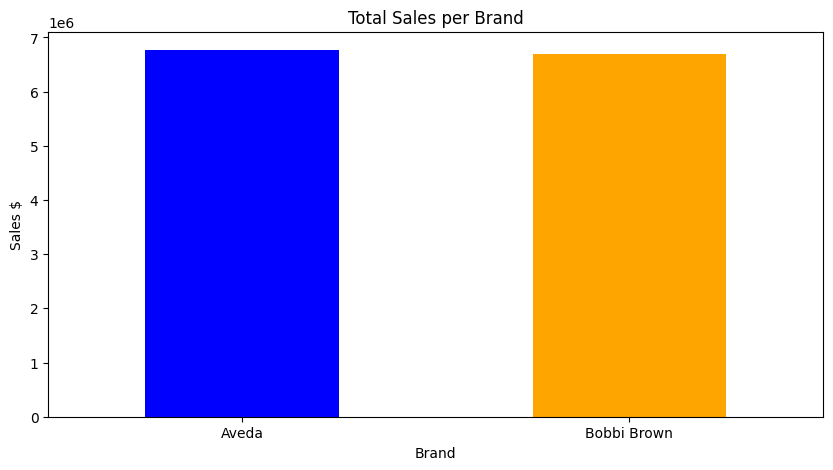

In [100]:
plt.figure(figsize=(10, 5))
df.groupby("Brand")["Sales"].sum().plot(kind="bar", color=["blue", "orange"])
plt.title("Total Sales per Brand")
plt.ylabel("Sales $")
plt.xticks(rotation=0)
plt.show()

In [115]:
from scipy.optimize import minimize

# Objective function: maximize total profit
def objective_profit(new_sales, margin):
  return -sum(new_sales * margin) # Negative sign for maximization (scipy minimizes by default)

# Constraints function
def constraint(new_sales, sales, min_contributions, max_contributions, total_sales, min_sales):
  contributions = new_sales / total_sales
  return np.hstack([
    contributions - min_contributions,
    max_contributions - contributions,
    new_sales - min_sales # make sure new_sales >= min_sales
    ])

# Extract data
sales = df["Sales"].to_numpy().astype(float)
trend = df["Trend"].to_numpy().astype(float)
margin = df["Margin"].to_numpy().astype(float)
min_contributions = df["Contribution"].to_numpy() * 0.8
max_contributions = df["Contribution"].to_numpy() * 1.2
total_sales = sum(sales)

# Set min_sales
min_sales = np.maximum(sales * 0.05, 1000)

# Compute initial estimate
trend = df["Trend"].to_numpy()
initial_guess = sales * (1 + trend)

# Define constraints
constraints = ({
    "type": "ineq",
    "fun": constraint,
    "args": (sales, min_contributions, max_contributions, total_sales, min_sales)
})

# Run optimization
result = minimize(objective_profit, initial_guess, args=(margin,), constraints=constraints, method="SLSQP")

if "Optimized Sales" not in df.columns:
    df["Optimized Sales"] = result.x

# Compute optimized sales and profit
df["Optimized Sales (Profit)"] = np.minimum(df["Optimized Sales"], df["Sales"] * 1.5)
df["Profit Increase"] = (df["Optimized Sales (Profit)"] * df["Margin"]) - (df["Sales"] * df["Margin"])
df["Original Profit"] = df["Sales"] * df["Margin"]
df["Optimized Profit"] = df["Optimized Sales"] * df["Margin"]

df.head()

,Brand,Segment,Sales,Margin,Trend,Contribution,Optimized Sales,Optimized Sales (Profit),Profit Increase,Original Profit,Optimized Profit
0,Bobbi Brown,Lipstick,4879625,0.06,0.08,0.722772,7319437.50,7319437.50,146388.7500,292777.50,439166.2500
1,Bobbi Brown,Mascara,906635,0.14,0.06,0.138614,1359952.50,1359952.50,63464.4500,126928.90,190393.3500
2,Bobbi Brown,Bronzer,906482,0.05,0.10,0.138614,1359723.00,1359723.00,22662.0500,45324.10,67986.1500
3,Aveda,Toner,2469011,0.14,0.04,0.360000,3703516.50,3703516.50,172830.7700,345661.54,518492.3100
4,Aveda,Mascara,689,0.05,-0.05,0.000000,654.55,654.55,-1.7225,34.45,32.7275


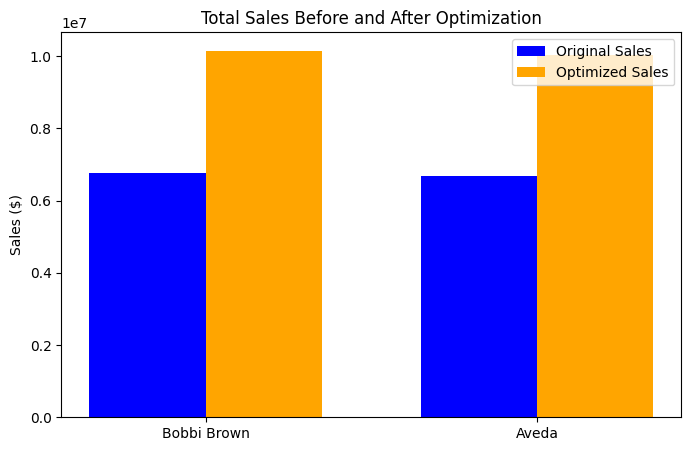

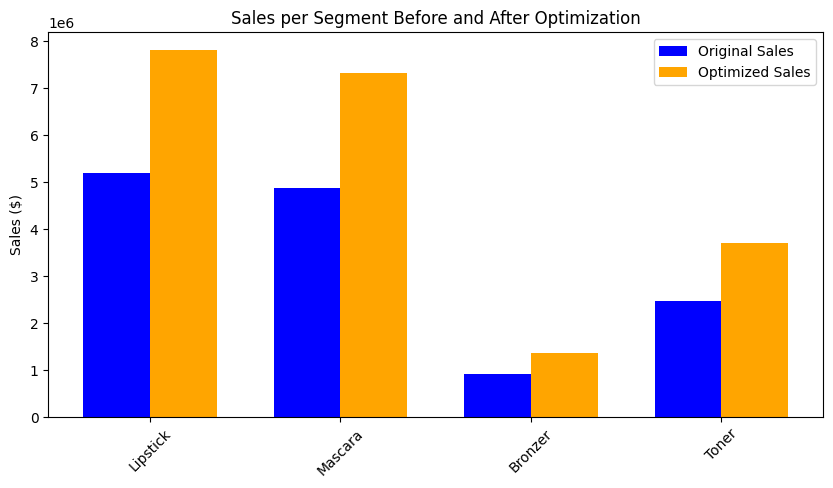

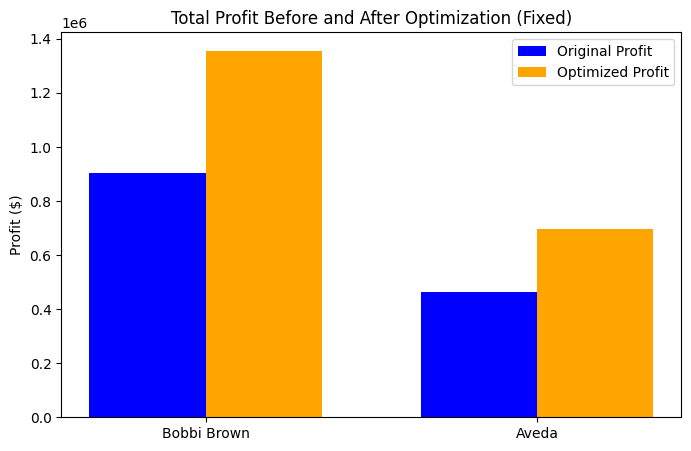

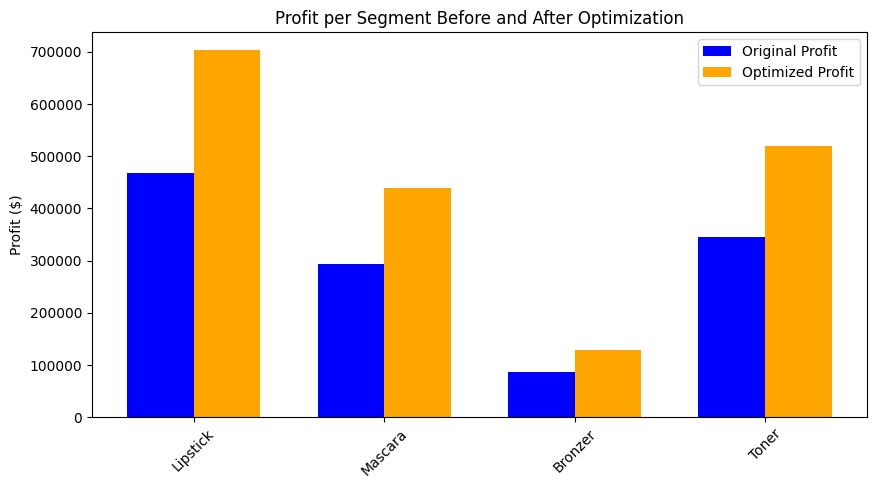

In [113]:
# Ensure Optimized Sales does not exceed 1.5x the original sales
df["Optimized Sales"] = np.minimum(df["Optimized Sales"], df["Sales"] * 1.5)

# Calculate Profit using the correct formula
df["Original Profit"] = df["Sales"] * df["Margin"]
df["Optimized Profit"] = df["Optimized Sales"] * df["Margin"]

# Define colors and bar width
colors = ["blue", "orange"]
width = 0.35

# Total Sales Before and After Optimization
x_labels = df["Brand"].unique()
sales_before = df.groupby("Brand")["Sales"].sum()
sales_after = df.groupby("Brand")["Optimized Sales"].sum()

x = np.arange(len(x_labels))
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, sales_before, width, label="Original Sales", color=colors[0])
ax.bar(x + width/2, sales_after, width, label="Optimized Sales", color=colors[1])

ax.set_ylabel("Sales ($)")
ax.set_title("Total Sales Before and After Optimization")
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend()
plt.show()

# Sales per Segment Before and After Optimization
segments = df["Segment"].unique()
sales_before_segment = df.groupby("Segment")["Sales"].sum()
sales_after_segment = df.groupby("Segment")["Optimized Sales"].sum()

x = np.arange(len(segments))
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x - width/2, sales_before_segment, width, label="Original Sales", color=colors[0])
ax.bar(x + width/2, sales_after_segment, width, label="Optimized Sales", color=colors[1])

ax.set_ylabel("Sales ($)")
ax.set_title("Sales per Segment Before and After Optimization")
ax.set_xticks(x)
ax.set_xticklabels(segments, rotation=45)
ax.legend()
plt.show()

# Total Profit Before and After Optimization
profit_before = df.groupby("Brand")["Original Profit"].sum()
profit_after = df.groupby("Brand")["Optimized Profit"].sum()

x = np.arange(len(x_labels))
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, profit_before, width, label="Original Profit", color=colors[0])
ax.bar(x + width/2, profit_after, width, label="Optimized Profit", color=colors[1])

ax.set_ylabel("Profit ($)")
ax.set_title("Total Profit Before and After Optimization (Fixed)")
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend()
plt.show()

# Profit per Segment Before and After Optimization
profit_before_segment = (df.groupby("Segment")["Sales"].sum() * df.groupby("Segment")["Margin"].mean())
profit_after_segment = (df.groupby("Segment")["Optimized Sales"].sum() * df.groupby("Segment")["Margin"].mean())

x = np.arange(len(segments))
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x - width/2, profit_before_segment, width, label="Original Profit", color=colors[0])
ax.bar(x + width/2, profit_after_segment, width, label="Optimized Profit", color=colors[1])

ax.set_ylabel("Profit ($)")
ax.set_title("Profit per Segment Before and After Optimization")
ax.set_xticks(x)
ax.set_xticklabels(segments, rotation=45)
ax.legend()
plt.show()


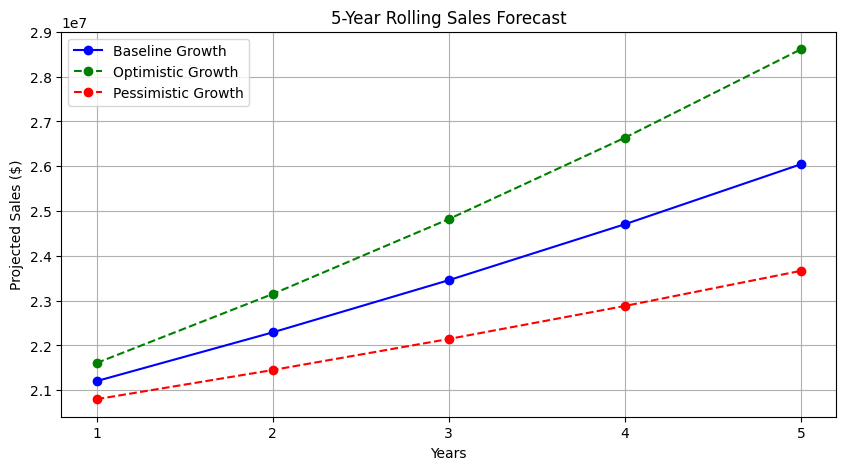

In [114]:
# Define the years for prediction
years = np.arange(1, 6)  # Year 1 to Year 5

# Extract necessary data
base_sales = df["Optimized Sales"].values
trend = df["Trend"].values

# Define different growth scenarios
baseline_growth = trend
optimistic_growth = trend + 0.02  # +2% additional growth
pessimistic_growth = trend - 0.02  # -2% decline

# Calculate future sales using compound growth formula
future_sales_baseline = np.array([base_sales * (1 + baseline_growth) ** y for y in years])
future_sales_optimistic = np.array([base_sales * (1 + optimistic_growth) ** y for y in years])
future_sales_pessimistic = np.array([base_sales * (1 + pessimistic_growth) ** y for y in years])

# Aggregate predictions by summing across all segments/brands
total_future_sales_baseline = future_sales_baseline.sum(axis=1)
total_future_sales_optimistic = future_sales_optimistic.sum(axis=1)
total_future_sales_pessimistic = future_sales_pessimistic.sum(axis=1)

# Plot future sales projection
plt.figure(figsize=(10, 5))
plt.plot(years, total_future_sales_baseline, marker='o', linestyle='-', label="Baseline Growth", color="blue")
plt.plot(years, total_future_sales_optimistic, marker='o', linestyle='--', label="Optimistic Growth", color="green")
plt.plot(years, total_future_sales_pessimistic, marker='o', linestyle='--', label="Pessimistic Growth", color="red")

plt.xlabel("Years")
plt.ylabel("Projected Sales ($)")
plt.title("5-Year Rolling Sales Forecast")
plt.xticks(years)
plt.legend()
plt.grid(True)
plt.show()
